In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture
from PIL import Image, ImageFilter
from scipy import signal
import random
import matplotlib.pyplot as plt
import cvxpy as cp
import rasterio

In [2]:
dest = '../../data/2nd Semester/images/'
save_dest = dest + 'Mod/'

In [3]:
Marseille_LST_DATA= []
Marseille_LST_IMAGES= []
Marseille_NDVI_IMAGES = []

max_temperature = 0
min_temperature = -300

#loading data
for i in range(12):
    with rasterio.open(dest+"LST/lst-Marseille-2023-"+str(i+1)+".tiff") as dataset:
        pixels = dataset.read(1)
        Marseille_LST_DATA.append(dataset.read(1))
        
        max = np.max(pixels)
        min = np.min(pixels)
        
        if max_temperature < max:
            max_temperature = max
            
        if min_temperature < min:
            min_temperature = min
            
    
    with rasterio.open(dest+"NDVI/ndvi-Marseille-2023-"+str(i+1)+".tiff") as dataset:
        Marseille_NDVI_IMAGES.append(Image.fromarray(dataset.read(1)*255))

# mapping temperatures min->0 max->255
for i in range(12):
    Marseille_LST_IMAGES.append((Image.fromarray(255*(Marseille_LST_DATA[0]-min_temperature)/(max_temperature - min_temperature))))

Marseille_LST_IMAGES[0]

<PIL.Image.Image image mode=F size=16x12>

In [4]:
# Dimensions of image
MSL_LST_size = Marseille_LST_IMAGES[0].size
MSL_NDVI_size = Marseille_NDVI_IMAGES[0].size
# total number of pixels
MSL_LST_pixel_num = MSL_LST_size[0]*MSL_LST_size[1]
MSL_NDVI_pixel_num = MSL_NDVI_size[0]*MSL_NDVI_size[1]

In [5]:
# Pixel versions of the images
MSL_LST_PIXELS = []
MSL_NDVI_PIXELS = []

for png in Marseille_LST_IMAGES:
    MSL_LST_PIXELS.append(np.array(png))

for png in Marseille_NDVI_IMAGES:
    MSL_NDVI_PIXELS.append(np.array(png))

In [6]:
highlight_kernel = np.array([[1.,1,1],[1,1,1],[1,1,1]])
highlight_kernel /= np.sum(highlight_kernel)
print(np.sum(highlight_kernel))

1.0


In [7]:
def merge_average(pixels_list):
    result = np.zeros(shape = pixels_list[0].shape)
    
    for img in pixels_list:
        result += img
    result /= len(pixels_list)

    return result

def merge_subtract(pixels_list):
    result = np.zeros(shape = pixels_list[0].shape)
    
    for i in range(len(pixels_list)-1):
        
        img1 = pixels_list[i]
        img2 = pixels_list[i+1]

        img = 255*(np.abs(img2 - img1)/255.)**0.5
        result += img
    result /= len(pixels_list)-1
    return 255*(result/255.)**0.9

In [9]:
# Averaging out the blurred images in one
MSL_LST_PxAvg = np.zeros(shape=MSL_LST_size).T
MSL_NDVI_PxAvg = np.zeros(shape=MSL_NDVI_size).T

MSL_LST_PxAvg = merge_average(MSL_LST_PIXELS)

MSL_NDVI_PxAvg = merge_average(MSL_NDVI_PIXELS)

MSL_LST_BLUR_PngAvg = Image.fromarray(MSL_LST_PxAvg).convert(mode='L').filter(ImageFilter.GaussianBlur(np.sqrt(MSL_LST_pixel_num)/1))
MSL_NDVI_BLUR_PngAvg = Image.fromarray(MSL_NDVI_PxAvg).convert(mode='L').filter(ImageFilter.GaussianBlur(np.sqrt(MSL_NDVI_pixel_num)/400))

MSL_LST_BLUR_PxAvg = np.array(MSL_LST_BLUR_PngAvg)
MSL_NDVI_BLUR_PxAvg = np.array(MSL_NDVI_BLUR_PngAvg)

In [10]:
MSL_LST_BLUR_MeanAvg = 0
MSL_NDVI_BLUR_MeanAvg = 0

MSL_LST_AVG_available_samples = []
MSL_NDVI_AVG_available_samples = []

for pxl in np.ndenumerate(MSL_LST_BLUR_PxAvg):
    MSL_LST_BLUR_MeanAvg += pxl[1]/MSL_LST_pixel_num
    MSL_LST_AVG_available_samples.append(pxl[0])
    
for pxl in np.ndenumerate(MSL_NDVI_BLUR_PxAvg):
    MSL_NDVI_BLUR_MeanAvg += pxl[1]/MSL_NDVI_pixel_num
    MSL_NDVI_AVG_available_samples.append(pxl[0])

Απο εδώ και πέρα θα ασχολούμαι μόνο με το Marseille_LST_AVG_BLUR

In [11]:
sample_count = int(MSL_NDVI_pixel_num * 0.2)
MSL_NDVI_samples = random.choices(MSL_NDVI_AVG_available_samples, k = sample_count)

MSL_NDVI_sample_values=[]
for xy in MSL_NDVI_samples:
    MSL_NDVI_sample_values.append(MSL_NDVI_BLUR_PxAvg[xy[0],xy[1]])
MSL_NDVI_sample_values = np.array(MSL_NDVI_sample_values)

x = np.linspace(0,255,30)
P = np.zeros(shape=(x.shape[0]-1))

for val in MSL_NDVI_sample_values:
    for bin in range(len(x)-1):
        
        if val <= x[bin+1]:
            P[bin] += 1
            break

P /= len(MSL_NDVI_samples)
P

array([1.48919348e-01, 1.53678321e-02, 1.88838461e-02, 2.99716438e-02,
       3.36054918e-02, 4.51038079e-02, 5.12387773e-02, 5.72673159e-02,
       6.24900221e-02, 6.31780205e-02, 7.45432983e-02, 7.43076303e-02,
       6.73288176e-02, 5.79477121e-02, 4.12799051e-02, 3.93261417e-02,
       3.17543580e-02, 2.74591192e-02, 2.22440152e-02, 1.55578869e-02,
       1.10687922e-02, 6.89518857e-03, 2.94584958e-03, 1.07951133e-03,
       2.12861389e-04, 2.28065774e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [12]:
mu = MSL_NDVI_BLUR_MeanAvg
sr = 0.3
X = np.linspace(0,(x[9]+x[8])/2,x.shape[0]-1)

In [18]:
w_var = cp.Variable(len(X))
obj = cp.Maximize(cp.sum(cp.multiply(w_var,cp.square(X))))

const = [
    cp.sum(w_var)==1,
    w_var >= 0.000000001,
    cp.sum(cp.multiply(w_var,X)) == mu,
    cp.multiply(sr,w_var)<=P
]

prob = cp.Problem(obj,const)
opt_v = prob.solve(solver=cp.CLARABEL)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

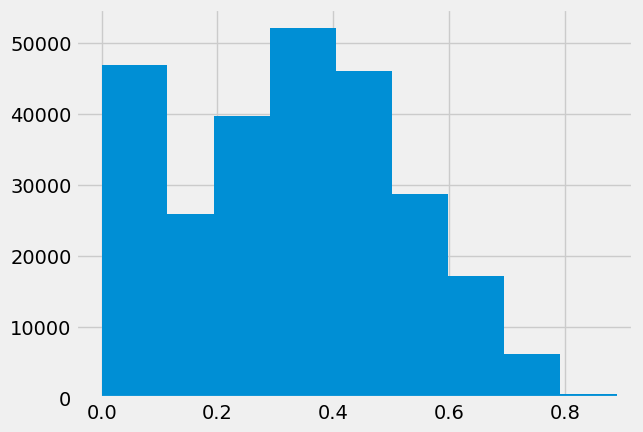

In [21]:
plt.hist(MSL_NDVI_sample_values/255.,bins=9,label='sample histogram',width=0.1*9/8)
plt.bar(np.linspace(0,1*8/9,9)+0.055,w_var.value*MSL_NDVI_sample_values.shape[0]+20,color='r',width=0.1*9/8,alpha=0.3,
        label='subsampling distribution')
plt.legend()
plt.show()

In [22]:
def mod_function(value):
    for i in range (len(P)):
        if value <= (i+1)/len(P)*255:
            
            return P[i]

In [23]:
MSL_NDVI_weights = np.zeros(shape=MSL_NDVI_sample_values.shape)
for i in range(MSL_NDVI_sample_values.shape[0]): 
    MSL_NDVI_weights[i] = mod_function(MSL_NDVI_sample_values[i])
    
MSL_NDVI_subsamples = random.choices(MSL_NDVI_samples, MSL_NDVI_weights**10, k = int(sample_count*sr))
MSL_NDVI_subsamples = np.array(MSL_NDVI_subsamples)

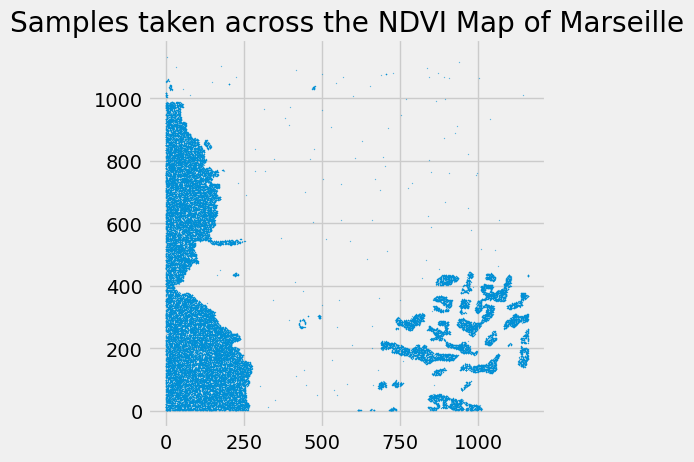

In [24]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()

ax.scatter(MSL_NDVI_subsamples[:,1], MSL_NDVI_size[1]- MSL_NDVI_subsamples[:,0], linewidth=0, s=0.9, alpha = 0.6)
plt.title('Samples taken across the NDVI Map of Marseille',)
ax.set_aspect('equal')
plt.show()

In [ ]:
gmm = GaussianMixture(n_components=10, random_state=0,).fit(MSL_NDVI_subsamples)

In [ ]:
X, Y = np.meshgrid(np.linspace(0, MSL_NDVI_size[1], MSL_NDVI_size[1]), np.linspace(0, MSL_NDVI_size[0], MSL_NDVI_size[0]))
XX = np.array([X.ravel(),Y.ravel()]).T
Z = gmm.score_samples(XX)
Z = -Z.reshape(X.shape)
levels = np.linspace(np.min(Z), np.max(Z), 20)

# plot
fig, ax = plt.subplots()

ax.contour(Y, MSL_NDVI_size[1]-X, Z, levels=levels, linewidths=0.7,alpha=0.4,cmap=plt.cm.gray)
ax.scatter(MSL_NDVI_subsamples[:,1], MSL_NDVI_size[1]- MSL_NDVI_subsamples[:,0], linewidth=0, alpha = 0.06, s=0.4,color='0')
ax.scatter(gmm.means_[:,1], MSL_NDVI_size[1]-gmm.means_[:,0], c='red', linewidth=0,s=3)
ax.set_aspect('equal')
plt.title('Sensor Placement')


plt.show()

In [ ]:
def mean(points, pixel_map):
    result=0
    for p in points:
        result += pixel_map[int(p[0]),int(p[1])]
    return result

def sdv(points, pixel_map, mean):
    result=0
    m = mean
    for p in points:
        result += (m-pixel_map[int(p[0]),int(p[1])])**2
    return np.sqrt(result/(points.shape[0]))

In [ ]:
costs=[]

for i in range(15):
    gmm = GaussianMixture(n_components=i+1, random_state=0).fit(MSL_LST_subsamples)
    costs.append(round(1/sdv(gmm.means_,MSL_NDVI_BLUR_PxAvg, MSL_NDVI_BLUR_MeanAvg)*100,8))


In [ ]:
costs